# 1. Load population data

In [1]:
import sys
import ast
from pathlib import Path
from shapely import wkt  # type: ignore
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore

# Add project root to path
project_root = Path().resolve().parents[4]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho

ROOT = "../../../../.."

# Read census sections' shapefile
shp_file = f'{ROOT}/{RAW_INE}/seccionado_2022/SECC_CE_20220101.shp'
census_sections = gpd.read_file(shp_file)

# Select columns and rename
census_sections = census_sections[['NPRO', 'CPRO', 'NMUN', 'CMUN', 'CUSEC', 'geometry']]
census_sections.rename(
    columns={
        'NPRO': 'prov',
        'CPRO': 'cpro',
        'NMUN': 'mun',
        'CMUN': 'cmun',
        'CUSEC': 'census_section'
        }, 
    inplace=True)

census_sections.head(3)

,prov,cpro,mun,cmun,census_section,geometry
0,Araba/Álava,01,Alegría-Dulantzi,001,0100101001,"MULTIPOLYGON (((539753.044 4743324.668, 539784..."
1,Araba/Álava,01,Alegría-Dulantzi,001,0100101002,"POLYGON ((539559.74 4745571.157, 539562.677 47..."
2,Araba/Álava,01,Amurrio,002,0100201001,"MULTIPOLYGON (((503618.553 4759559.798, 503620..."


In [2]:
# Read census section's population data
population_dir = f'{ROOT}/{RAW_DATA}/ine'
population = f'{population_dir}/ine_census_section_population.parquet'
df_pop = pd.read_parquet(population)
df_pop.rename(columns={'muni_dist_section': 'census_section'}, inplace=True)

# Group by census section and sum population
df_pop['population'] = df_pop['population'].astype(int)
df_pop = df_pop.groupby('census_section')['population'].sum().reset_index()

df_pop.head(3)

,census_section,population
0,0100101001,1388
1,0100101002,1572
2,0100201001,1875


In [3]:
# Merge with census sections
census_sections = census_sections.merge(df_pop, on='census_section', how='left')
census_sections.head(3)

,prov,cpro,mun,cmun,census_section,geometry,population
0,Araba/Álava,01,Alegría-Dulantzi,001,0100101001,"MULTIPOLYGON (((539753.044 4743324.668, 539784...",1388.0
1,Araba/Álava,01,Alegría-Dulantzi,001,0100101002,"POLYGON ((539559.74 4745571.157, 539562.677 47...",1572.0
2,Araba/Álava,01,Amurrio,002,0100201001,"MULTIPOLYGON (((503618.553 4759559.798, 503620...",1875.0


# 2. Top 10 cities with most population

In [ ]:
print(f"Unique provinces: \n{census_sections['prov'].unique()}")
print(f"\nUnique municipalities: {len(census_sections['mun'].unique()):,}")
print(f"\nUnique census sections: {len(census_sections['census_section'].unique()):,}")

# Print top 10 cities with most population
print(f"\nTop 10 cities with most population:")
top_10_cities = census_sections.groupby('mun')['population'].sum().sort_values(ascending=False).head(10)
print(top_10_cities)

top_10_cities = top_10_cities.reset_index()['mun'].tolist()

Unique provinces: 
['Araba/Álava' 'Albacete' 'Alicante' 'Almería' 'Ávila' 'Badajoz'
 'Balears, Illes' 'Barcelona' 'Burgos' 'Cáceres' 'Cádiz'
 'Castellón/Castelló' 'Ciudad Real' 'Córdoba' 'Coruña, A' 'Cuenca'
 'Girona' 'Granada' 'Guadalajara' 'Gipuzkoa' 'Huelva' 'Huesca' 'Jaén'
 'León' 'Lleida' 'Rioja, La' 'Lugo' 'Madrid' 'Málaga' 'Murcia' 'Navarra'
 'Ourense' 'Asturias' 'Palencia' 'Palmas, Las' 'Pontevedra' 'Salamanca'
 'Santa Cruz de Tenerife' 'Cantabria' 'Segovia' 'Sevilla' 'Soria'
 'Tarragona' 'Teruel' 'Toledo' 'Valencia/Valéncia' 'Valladolid' 'Bizkaia'
 'Zamora' 'Zaragoza' 'Ceuta' 'Melilla']

Unique municipalities: 8,114

Unique census sections: 36,382

Top 10 cities with most population:
mun
Madrid                         3280782.0
Barcelona                      1636193.0
València                        792492.0
Sevilla                         681998.0
Zaragoza                        673010.0
Málaga                          579076.0
Murcia                          462979.0
Palma  

València


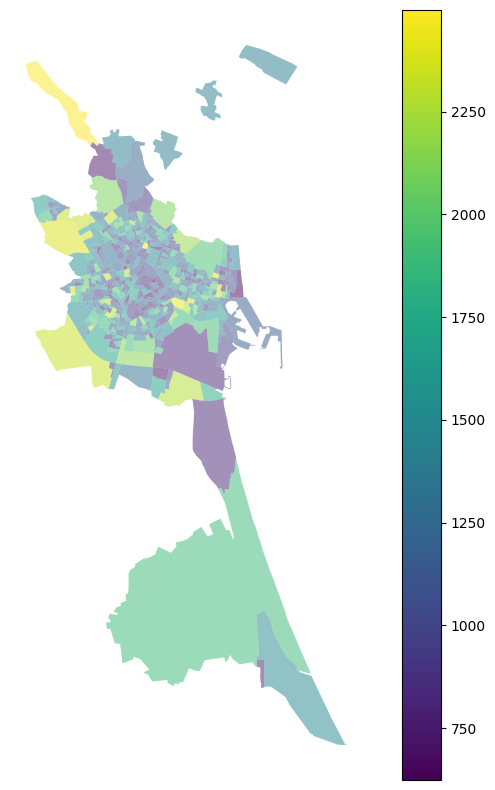

Sevilla


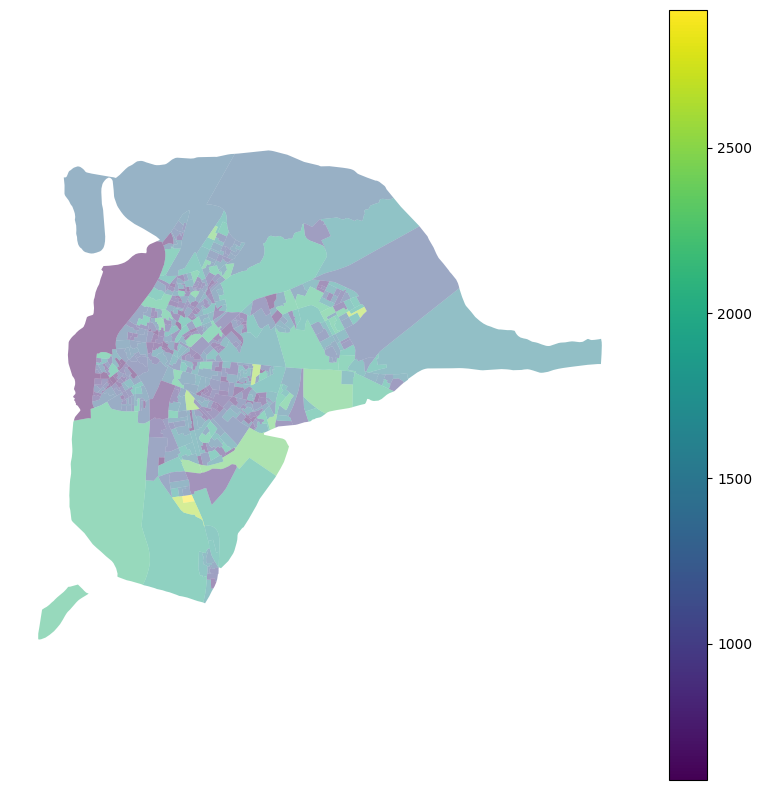

Zaragoza


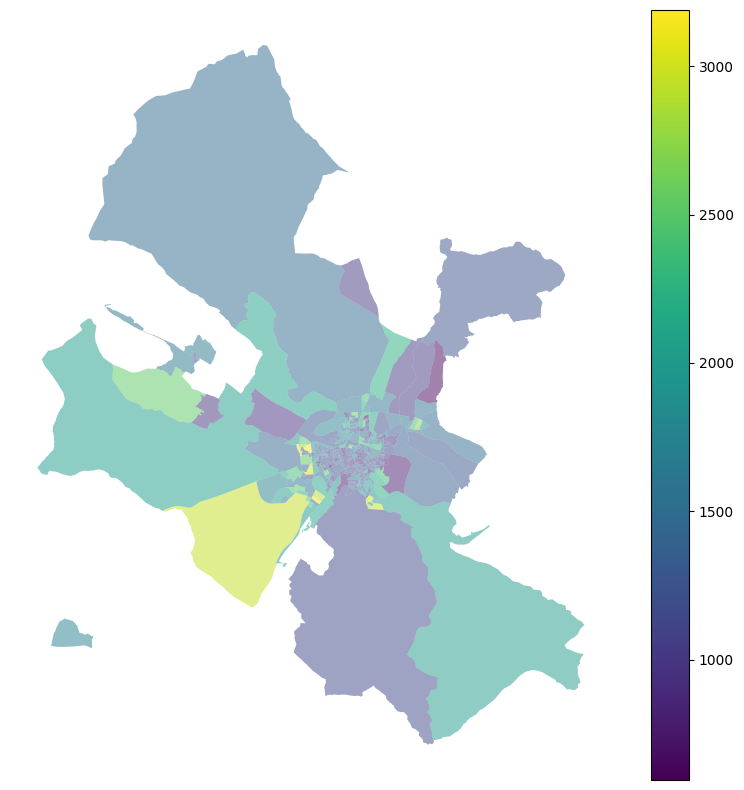

Málaga


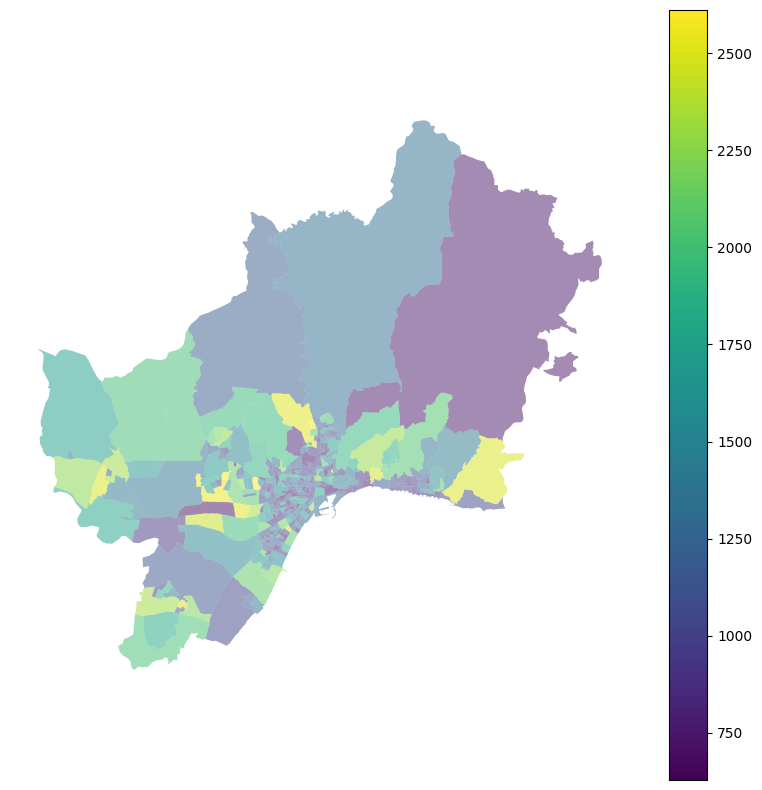

Murcia


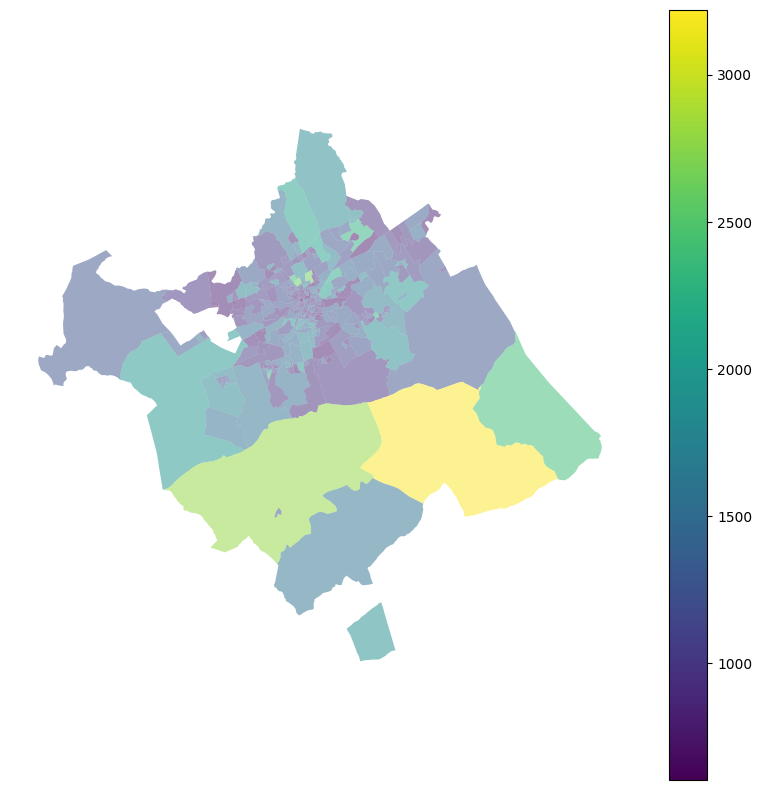

Palma


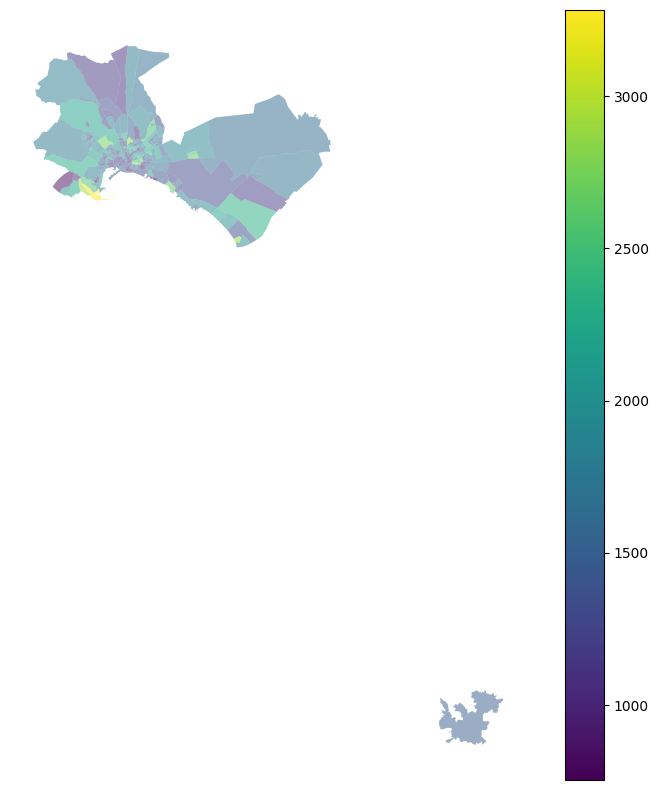

Palmas de Gran Canaria, Las


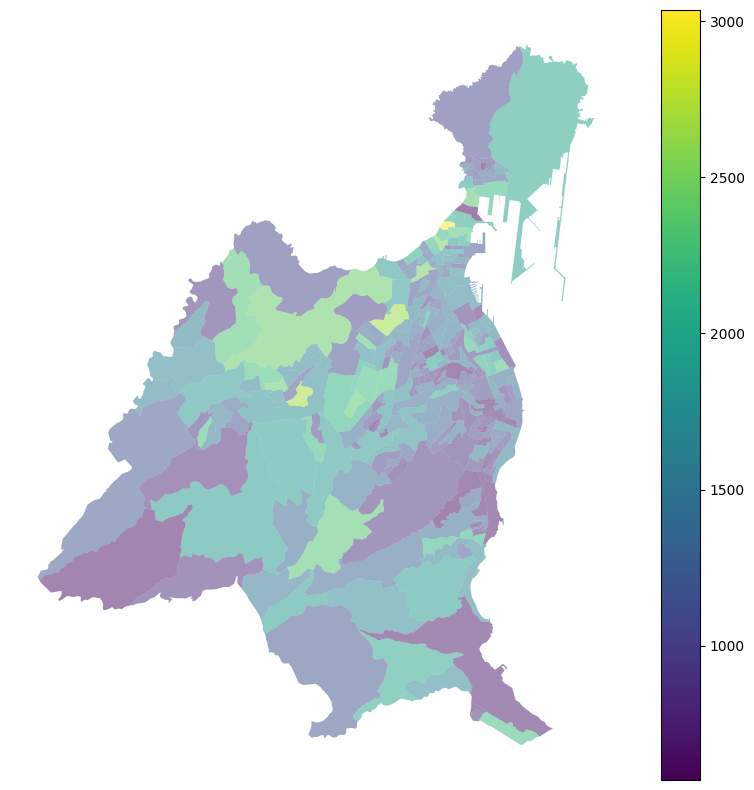

Bilbao


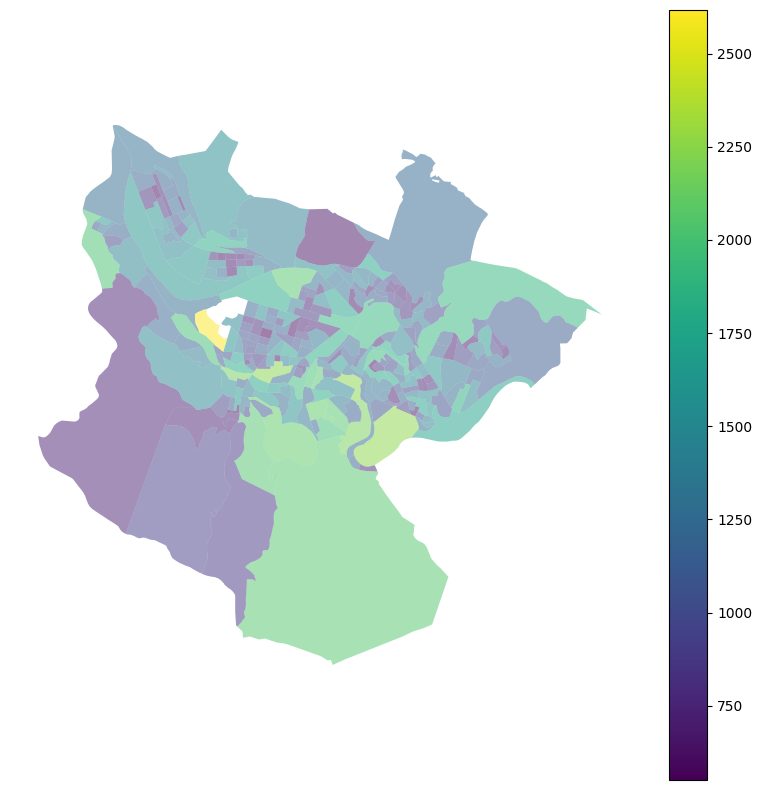

In [5]:
for city in top_10_cities[2:]:
    print(city)

    # Filter census sections for the city
    city_cs = census_sections[census_sections['mun'] == city]
    
    # Plot census sections
    fig, ax = plt.subplots(figsize=(10, 10))
    city_cs.plot(ax=ax, column='population', alpha=0.5, legend=True)
    ax.axis('off')
    plt.show()
    plt.close()


# 3. Download OSM bike network

In [6]:
import pickle
import os
import osmnx as ox

from src.assign_to_nodes.utils.assign_altitude import get_nodes_altitude
from src.assign_to_nodes.utils.fix_directed_graph import fix_directed_graph

def download_fix_and_save_graph(location, graph_file, crs, root, graph_path):
    """Helper function to download a graph, add edges on nodes with only one 
    directed edge, project the graph and save in both pickle (protocol 5) and 
    GraphML formats.
    
    Args:
        location (str): The location to download the graph from
        graph_file (str): The path to save the graph with protocol 5
        crs (int): The CRS of the graph
        root (str): The root directory of the project
        graph_path (str): The path to save the graph

    Returns:
        nx.MultiDiGraph: The fixed graph
    """
    # Download graph first
    G = ox.graph_from_place(location, network_type='bike', simplify=True, retain_all=False)
    G = ox.project_graph(G)
    
    # Create temporary nodes_gdf for fix_directed_graph
    temp_nodes_gdf, _ = ox.graph_to_gdfs(G)
    temp_nodes_gdf = temp_nodes_gdf.to_crs(crs)
    
    # Fix the graph
    G = fix_directed_graph(G, temp_nodes_gdf, root, plots=False)

    # Convert edge weights to float
    for u, v, key, data in G.edges(data=True, keys=True):
        if 'weight' in data:
            G.edges[u, v, key]['weight'] = float(data['weight'])
    
    # Get altitude data and integrate it into the graph
    G = get_nodes_altitude(G, root)

    # Compute altitude differences for each directed edge
    for u, v, key, data in G.edges(data=True, keys=True):
        # Get altitudes of source and target nodes
        source_alt = G.nodes[u]['altitude']
        target_alt = G.nodes[v]['altitude']
        
        # Compute altitude difference (target - source)
        elevation = target_alt - source_alt
        
        # Add as edge attribute
        G.edges[u, v, key]['elevation'] = round(elevation, 2)
    
    # Save the graph in both formats
    if graph_path:
        Path(f"{root}{graph_path}").mkdir(parents=True, exist_ok=True)
        
        # Save as pickle with protocol 5
        print(f"Saving graph to {graph_file} with protocol 5")
        with open(graph_file, "wb") as f:
            pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
            
    return G

crs = 25830
graph_path = f"{ROOT}/{RAW_GRAPH}"
city_rename = {'Palmas de Gran Canaria, Las': 'Palmas de Gran Canaria'}

for city in top_10_cities[2:4]: # Skip Madrid and Barcelona
    print(city)
    # Apply renaming if city is in the mapping
    if city in city_rename:
        city = city_rename[city]

    # Define location and graph file
    location = f"{city}, Spain"
    graph_file = f"{graph_path}/different_cities/bike_graph_{city}.pickle"

    # Download and save graph if it doesn't exist
    if not os.path.exists(graph_file):
        download_fix_and_save_graph(location, graph_file, crs, ROOT, graph_path)

València
Sevilla


# 4. Download residential buildings

In [7]:
from src.create_input_dataset.socioeconomic_helper import download_residential_buildings
EPSG = 25830

for i, city in enumerate(top_10_cities[1:2]):
    # Apply renaming if city is in the mapping
    print(city)
    if city in city_rename:
        city = city_rename[city]
    
    # if city == 'Palmas de Gran Canaria': continue
    
    location = f"{city}, Spain"
    print(f"({i}/{len(top_10_cities[2:])}) Downloading residential buildings for {location}")
    
    if city == 'Palmas de Gran Canaria':
        EPSG = 25828
    elif city == 'Barcelona':
        EPSG = 25831
    else:
        EPSG = 25830
    download_residential_buildings(location, save=True, save_fig=True, epsg=EPSG, root=ROOT)

Barcelona
(0/8) Downloading residential buildings for Barcelona, Spain


['residential' nan 'apartments' 'dormitory' 'yes' 'house' 'detached'
 'yes;apartments' 'semidetached_house' 'farm_auxiliary' 'farm' 'parish']
[nan 'apartments' 'dormitory' 'aparthotel']
[nan]
[nan]
[nan]
[nan]
[nan]
['Centre de Vida Independent' 'Apartaments City Center' 'SilPilates'
 'vivagym' nan 'Happy People Sagarda Familia Gaudí' 'Beyoo Poble Sec'
 'Napols Apart;Aparthotel Nàpols' 'Associació In Via'
 'Josefines de la Caritat' 'Residència Universitaria La ciutadella'
 'Residència Onix' 'Mestral Mar' 'Barcelona Residencias'
 "Residencia d'estudiant Mare Caterina"
 'Alexandra Barcelona Hotel, Curio Collection by Hilton' 'Monument Hotel'
 'Residencia e Institución Javeriana'
 'Residència Estudiants Religiosa Maria Immaculada'
 'Residència Universitaria Apimec' 'Residència Estudiants Lumen'
 'Residència Juvenes'
 'Residència Estudiants Nuestra Señora de la Consolación'
 'Residència Nikbor' 'Residència Universitària Augusta'
 'Residència Teatinas Immaculada Concepció' 'Residència Anton

# 5. Assign population to bike network

In [26]:
from src.assign_to_nodes.utils.class_node_assigner import NodeAttributesAssigner


graph_path = f"{RAW_GRAPH}/different_cities"

all_ass = {}

for i, city in enumerate(top_10_cities[2:]):

    # Population data
    city_cs_pop = census_sections[census_sections['mun'] == city]



    # Apply renaming if city is in the mapping
    if city in city_rename:
        city = city_rename[city]

    

    if city != 'Palmas de Gran Canaria': continue

    if city == 'Palmas de Gran Canaria':
        EPSG = 25828
    else:
            EPSG = 25830
    
    city_cs_pop = city_cs_pop.to_crs(epsg=EPSG)
    
    # Residential buildings data
    df_buildings = gpd.read_file(f"{ROOT}/{RAW_OSM}/{city}_Spain_residential_buildings.csv")
    df_buildings['geometry'] = df_buildings['geometry'].apply(wkt.loads)
    df_buildings = gpd.GeoDataFrame(df_buildings, geometry='geometry', crs=EPSG)
    df_buildings = df_buildings[['element', 'id', 'geometry']]

    # Node assigner
    node_assigner = NodeAttributesAssigner(city, graph_path, EPSG, ROOT, buffer_size=300)
    
    # Assign population and density
    node_assigner.assign_population_and_density(
        buildings_gdf = df_buildings,
        population_gdf = city_cs_pop,
        weight_by = 'equally',
        aggregation = 'sum',
        fillna_value = 0,
    )

    node_assigner.save_node_attributes()

	Successfully loaded graph with protocol 5
	No existing attributes found in ../../../../../data/raw/graph/different_cities/node_attributes_Palmas de Gran Canaria.csv.
	There is these files: ['node_mappings_protocol4_Zaragoza.pkl', 'node_mappings_Sevilla.pkl', 'node_mappings_protocol4_Palmas de Gran Canaria.pkl', 'node_attributes_Málaga.csv', 'distance_matrix_Sevilla.npy', 'distance_matrix_Bilbao.npy', 'node_attributes_Bilbao.csv', 'node_mappings_València.pkl', 'distance_matrix_València.npy', 'distance_matrix_Palma.npy', 'bike_graph_Murcia.pickle', 'distance_matrix_Zaragoza.npy', 'bike_graph_Palmas de Gran Canaria.pickle', 'bike_graph_Palma.pickle', 'node_mappings_protocol4_València.pkl', 'bike_graph_València.pickle', 'node_attributes_València.csv', 'node_attributes_Sevilla.csv', 'bike_graph_Málaga.pickle', 'node_mappings_Palma.pkl', 'distance_matrix_Palmas de Gran Canaria.npy', 'bike_graph_Sevilla.pickle', 'node_mappings_Bilbao.pkl', 'node_mappings_Palmas de Gran Canaria.pkl', 'node_at

In [20]:
census_sections[census_sections['mun'].str.startswith('Palmas')]

,prov,cpro,mun,cmun,census_section,geometry,population
25234,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501601001,"POLYGON ((-724975.059 3171310.056, -724980.079...",739.0
25235,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501601003,"POLYGON ((-724584.114 3171024.159, -724676.51 ...",1151.0
25236,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501601004,"POLYGON ((-724676.51 3171053.38, -724735.617 3...",685.0
25237,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501601005,"POLYGON ((-724990.44 3171171.608, -724983.416 ...",1571.0
25238,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501601006,"POLYGON ((-724660.923 3170790.532, -724666.496...",1527.0
...,...,...,...,...,...,...,...
25504,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501605031,"POLYGON ((-731033.534 3171994.589, -731034.448...",1581.0
25505,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501605032,"POLYGON ((-732246.182 3171229.42, -732261.543 ...",1486.0
25506,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501605033,"POLYGON ((-732532.014 3170513.5, -732447.813 3...",818.0
25507,"Palmas, Las",35,"Palmas de Gran Canaria, Las",016,3501605034,"POLYGON ((-732352.224 3170571.005, -732374.415...",1507.0
